In [1]:
import sys
import os
import logging
sys.path.insert(1, os.path.join(sys.path[0], '../../src'))
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

In [2]:
import torch
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [3]:
from datasets import ShellDataset, PaloAltoDataset, BoulderDataset
from visualization import plot_time_series_predictions

# Shell Dataset

### Load Dataset

In [4]:
dataset = ShellDataset(subset=3)
data = dataset.load_dataset()

In [5]:
print("Number of data points in train, test: ", len(data['train']),  len(data['test']))

Number of data points in train, test:  828 207


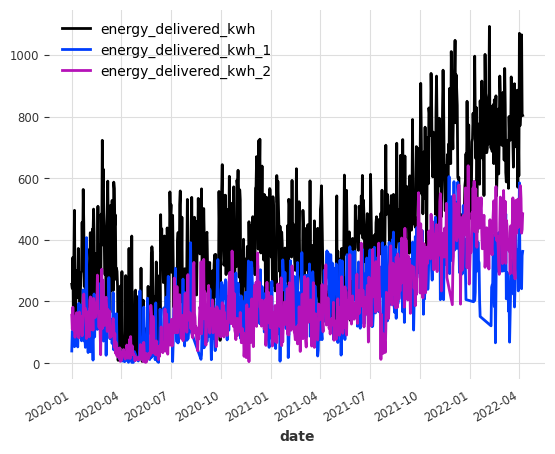

In [6]:
data['train'].plot()

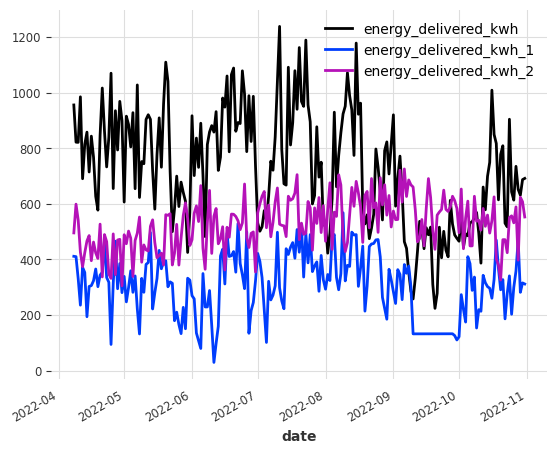

In [7]:
data['test'].plot()

### Set Experiment Parameters

In [8]:
TRAIN_GLOBAL=False
RETRAIN=False
FORECAST_HORIZON=[1, 7, 30]

In [9]:
from models.train import train_predict

In [10]:
predictions = {}
predictions['Actual'] = data['test']

## Run experiment

In [ ]:
from darts.utils.timeseries_generation import Holiday, Weekend

add_encoders = {
    'cyclic': {'future': ['month']},
    'datetime_attribute': {'future': ['dayofweek']},
    'position': {'past': ['relative'], 'future': ['relative']},
    'custom': {'past': [lambda idx: (idx.year - 1950) / 50]},
    'weekend': Weekend(),
    'holiday': Holiday(country_code='UK')
}

#### ARIMA

In [11]:
def load_arimamodel():
    from darts.models import ARIMA
    return ARIMA(
        p=30,
        d=1,
        q=30
    )

In [12]:
%%capture
predictions_arima = train_predict(
        train_series=data['train'],
        test_series=data['test'],
        split_val=None, 
        load_model_func=load_arimamodel,
        train_global=False,
        forecast_horizon=FORECAST_HORIZON,
        scale=False,
        retrain=RETRAIN,
        num_samples=1,
    )
predictions['ARIMA'] = predictions_arima

#### XGBoost

In [13]:
def load_xgbmodel():
    from darts.models import XGBModel
    return XGBModel(
        lags=30,
        add_encoders=add_encoders,
        output_chunk_length=7,
    )

In [14]:
%%capture
predictions_xgb = train_predict(
        train_series=data['train'],
        test_series=data['test'],
        split_val=0.8, 
        load_model_func=load_xgbmodel,
        train_global=False,
        forecast_horizon=FORECAST_HORIZON,
        scale=False,
        retrain=RETRAIN,
        num_samples=1,
    )
predictions['XGBoost'] = predictions_xgb

#### DeepAR

In [15]:
from darts.models import RNNModel
from darts.utils.likelihood_models import GaussianLikelihood
# from dart
def load_deeparmodel():
    return RNNModel(
        model="LSTM",
        hidden_dim=150, 
        n_rnn_layers=3,
        dropout=0.2,
        batch_size=64,
        add_encoders=add_encoders,
        optimizer_kwargs={'lr': 1e-3}, 
        nr_epochs_val_period=1,
        # log_tensorboard=logdir,
        input_chunk_length=30,
        output_chunk_length=7,
        random_state=0,
        likelihood=GaussianLikelihood(),
        n_epochs=100,
        # loss_fn=torch.nn.MSELoss(),
        # pl_trainer_kwargs={"callbacks": [EarlyStopping(monitor="val_loss", patience=5, min_delta=0.01, mode='min')], "log_every_n_steps": 1},
    )

In [16]:
%%capture
predictions_deepar = train_predict(
        train_series=data['train'],
        test_series=data['test'],
        # split_val=0.8, 
        split_val=None,
        load_model_func=load_deeparmodel,
        train_global=False,
        forecast_horizon=FORECAST_HORIZON,
        scale=True,
        retrain=RETRAIN,
        num_samples=50,
    )
predictions['DeepAR'] = predictions_deepar

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 454 K 
4 | V             | Linear           | 302   
---------------------------------------------------
454 K     Trainable params
0         Non-trainable params
454 K     Total params
1.818     Total estimated model params size (MB)


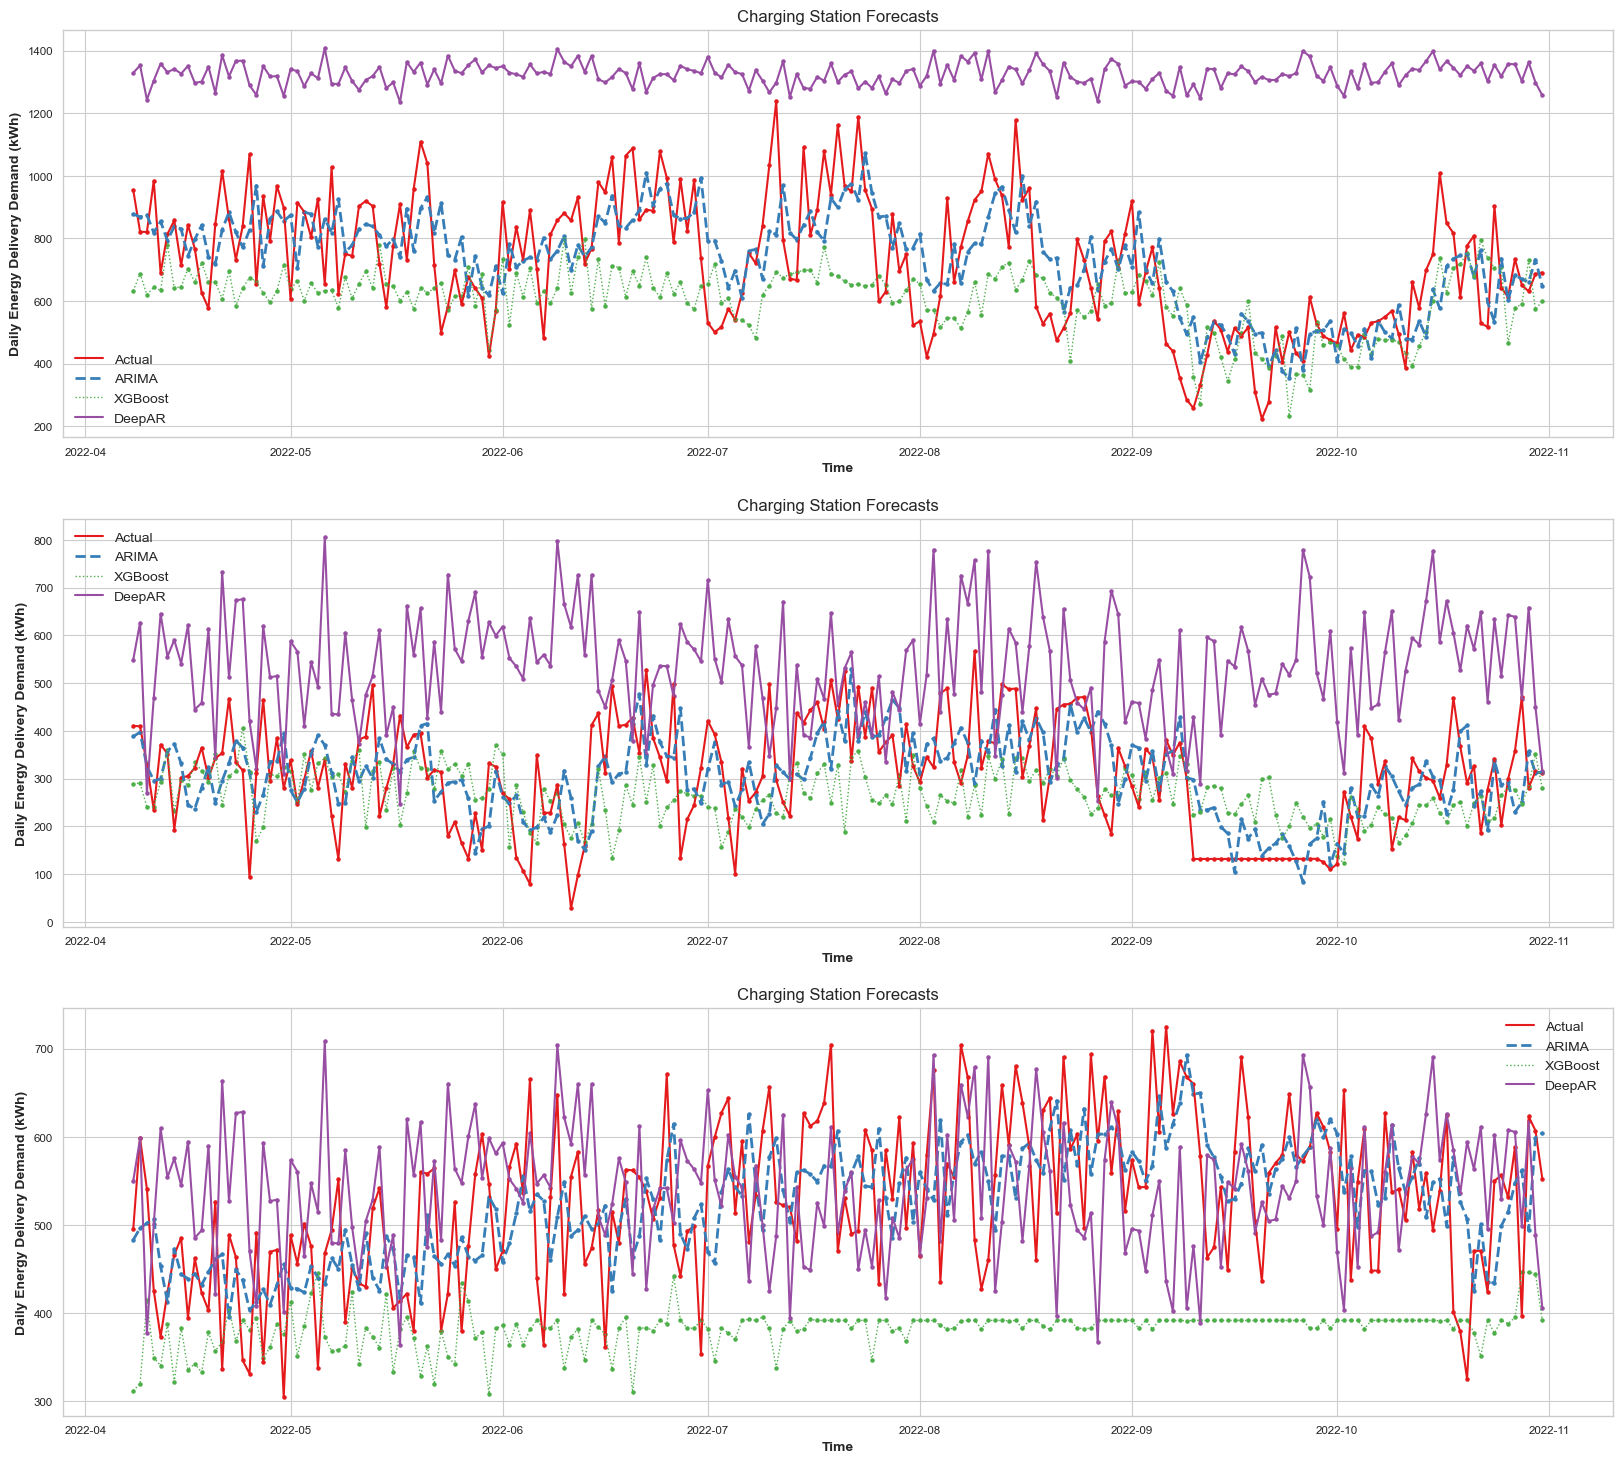

In [ ]:
plot_time_series_predictions(predictions)

#### TCN

In [ ]:
from darts.models import TCNModel

def load_tcnmodel():
    return TCNModel(
        input_chunk_length=30,
        output_chunk_length=FORECAST_HORIZON,
        batch_size=16,
        num_layers=1,
        dilation_base=2,
        kernel_size=4,
        num_filters=3,
        # weight_norm=True,
        dropout=0.2,
        likelihood=None,
        loss_fn=torch.nn.MSELoss(),
        optimizer_kwargs={'lr': 0.005}, 
        nr_epochs_val_period=1,
        add_encoders=add_encoders,
        # log_tensorboard=True,
        n_epochs=20,
        random_state=0,
        pl_trainer_kwargs={"callbacks": [EarlyStopping(monitor="val_loss", patience=5, min_delta=0.01, mode='min')], "log_every_n_steps": 1},
    )

In [ ]:
%%capture
predictions_tcn = train_predict(
        train_series=data['train'],
        test_series=data['test'],
        split_val=0.8, 
        load_model_func=load_tcnmodel,
        train_global=False,
        forecast_horizon=FORECAST_HORIZON,
        scale=False,
        retrain=RETRAIN,
        num_samples=1,
    )
predictions['TCN'] = predictions_tcn

# Results

In [ ]:
from darts.metrics import mape, rmse

def print_metrics(predictions_dict):
    max_name_length = max(len(name) for name in predictions_dict.keys())
    mape_header = "MAPE"
    rmse_header = "RMSE"
    
    print(f"{'Model':{max_name_length}} | {mape_header:<10} | {rmse_header:<10}")
    print("-" * (max_name_length + 26))
    
    for name, forecast_dict in predictions_dict.items():
        for horizon, predictions in forecast_dict.items():
            mape_value = mape(predictions, data['test'])
            rmse_value = rmse(predictions, data['test'])
            print(f"{name:{max_name_length}} (Horizon: {horizon}) | {mape_value:<10.4f} | {rmse_value:<10.4f}")


In [ ]:
print_metrics(predictions)

Model   | MAPE       | RMSE      
---------------------------------
Actual  | 0.0000     | 0.0000    
ARIMA   | 19.4056    | 113.4331  
XGBoost | 36.3023    | 167.8638  
DeepAR  | 34.2256    | 329.9066  
TCN     | 19.9637    | 114.0267  


# Visualization

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_time_series_predictions(predictions_dict):
    sns.set_style("whitegrid")
    colors = sns.color_palette("Set1", len(predictions_dict))
    line_styles = ['-', '--', ':']  # Different line styles for each model
    line_widths = [1.5, 2.0, 1.0]  # Different line widths for each model

    # Calculate the number of rows and columns for subplots
    num_plots = list(predictions_dict.values())[0].n_components

    # Create a figure and subplots
    fig, axs = plt.subplots(num_plots, 1, figsize=(20, 6 * num_plots))

    # Flatten the subplots array if necessary
    if num_plots == 1:
        axs = [axs]

    # Iterate over the models and their predictions
    for i, (model, predictions) in enumerate(predictions_dict.items()):
        # Generate x values
        x = range(len(predictions[0]))

        # Iterate over predictions and plot each time series separately
        for j in range(predictions.n_components):
            time_series = predictions.univariate_component(j)
            x = time_series.time_index
            # Plot the time series line with different styles
            axs[j].plot(x, time_series.values(), color=colors[i], linestyle=line_styles[i % len(line_styles)],
                        linewidth=line_widths[i % len(line_widths)], label=f"{model}")

            # Plot points on the line indicating the predictions
            axs[j].scatter(x, time_series.values(), color=colors[i], marker='o', s=5, label=None)

            # Set labels and title for each subplot
            axs[j].set_xlabel('Time')
            axs[j].set_ylabel('Daily Energy Delivery Demand (kWh)')
            axs[j].set_title(f'Charging Station Forecasts')

            # Show legend for each subplot
            axs[j].legend()

    # Adjust spacing between subplots
    # plt.tight_layout()

    # Display the plot
    plt.show()


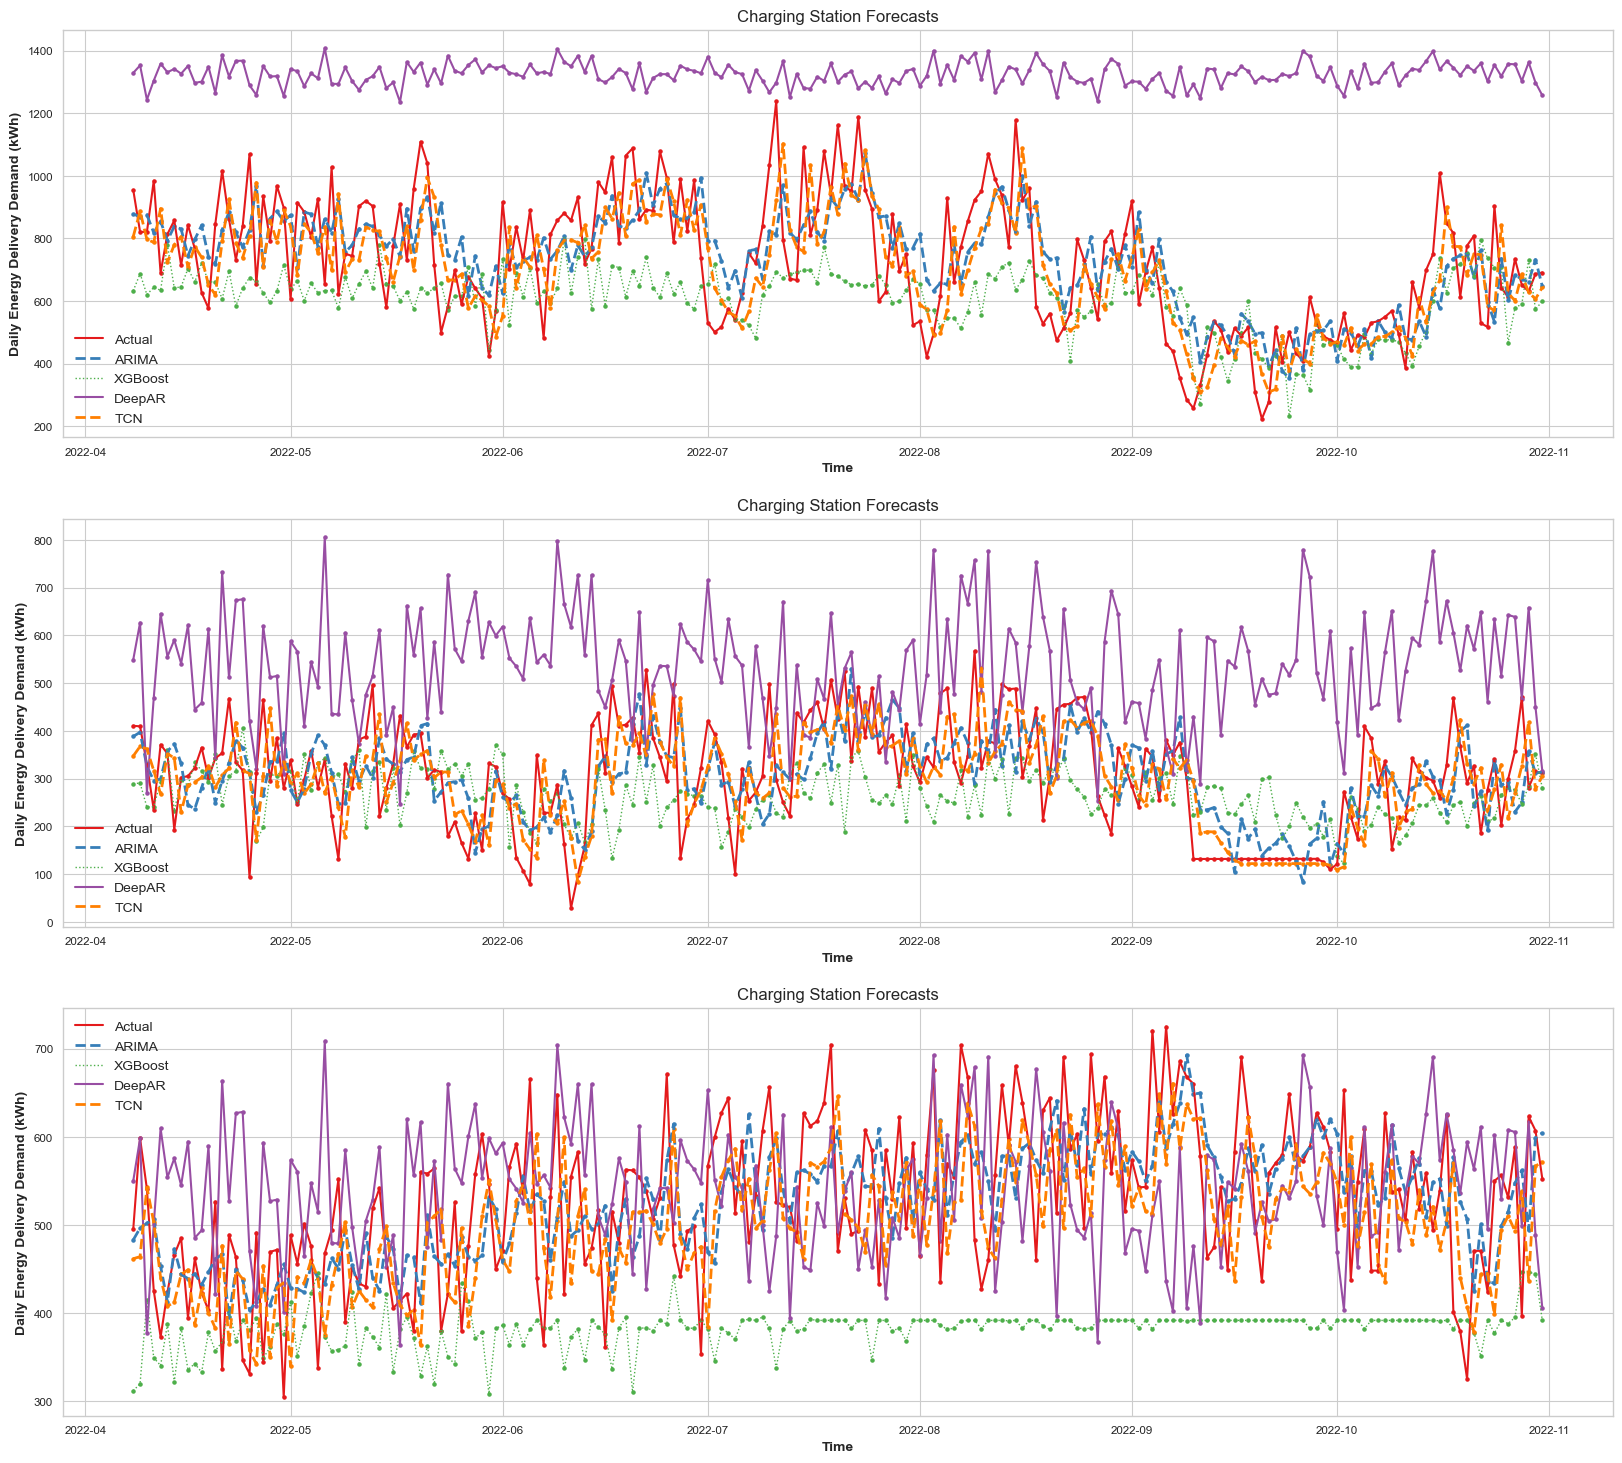

In [ ]:
plot_time_series_predictions(predictions)
